<a href="https://colab.research.google.com/github/VladimirBlinov/Patterns_recognition/blob/main/Patterns_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# There is an model for pattern detection in financial timeseries.
It makes smooth of timeseries, finds extremums, considers combination of max and min as a kind of pattern.

The traning dataset will be created with features: timeseries points ensamble, max&min points. 

The labels will be patterns OHE.

The models after training will consider the probability of patterns in timeseries window.

In [1]:
!pip install finam-export

In [2]:
pip install mplfinance

     |████████████████████████████████| 71kB 5.5MB/s 


In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

import mplfinance as mpf
import logging
import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from finam import Exporter, Market, LookupComparator, Timeframe
from finam.utils import click_validate_enum

from scipy.signal import gauss_spline
from scipy.signal import argrelextrema

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
# Load market data
exporter = Exporter()
msft = exporter.lookup(market=Market.USA, name='Microsoft',
                          name_comparator=LookupComparator.CONTAINS)
assert len(msft) == 1
data_initial = exporter.download(msft.index[0], market=Market.USA, timeframe=Timeframe.MINUTES15)  # Download data for stock
print(data_initial.tail()) 

         <DATE>    <TIME>  <OPEN>  <HIGH>   <LOW>  <CLOSE>   <VOL>
15347  20210507  21:45:00  252.48  253.24  252.47   253.16   28202
15348  20210507  22:00:00  253.17  253.47  252.91   253.20   53200
15349  20210507  22:15:00  253.20  253.33  252.83   252.92   58910
15350  20210507  22:30:00  252.92  253.14  252.61   252.73   45265
15351  20210507  22:45:00  252.68  253.22  252.32   252.42  151258


In [5]:
data = data_initial.copy()  # Make copy of initial dataset
data['Date'] = data['<DATE>'].astype(str) + ' ' + data['<TIME>']  # Concatenate data columns as str
data.index = pd.to_datetime(data['Date'])  # Transform index to datetime format
del data['<DATE>'], data['<TIME>'], data['Date']  # Delete initial columns with date

In [6]:
# Rename columns
data = data.rename(columns={'<OPEN>': 'Open', '<HIGH>': 'High', '<LOW>': 'Low', '<CLOSE>': 'Close', '<VOL>': 'Volume' })
data

,Open,High,Low,Close,Volume
Date,,,,,
2007-01-03 17:30:00,29.91,30.01,29.8800,29.99,4931482
2007-01-03 17:45:00,29.95,29.98,29.8499,29.85,2478193
2007-01-03 18:00:00,29.85,29.92,29.8300,29.91,1454263
2007-01-03 18:15:00,29.90,29.97,29.8800,29.97,2963767
2007-01-03 18:30:00,29.97,30.00,29.9400,30.00,2840720
...,...,...,...,...,...
2021-05-07 21:45:00,252.48,253.24,252.4700,253.16,28202
2021-05-07 22:00:00,253.17,253.47,252.9100,253.20,53200
2021-05-07 22:15:00,253.20,253.33,252.8300,252.92,58910


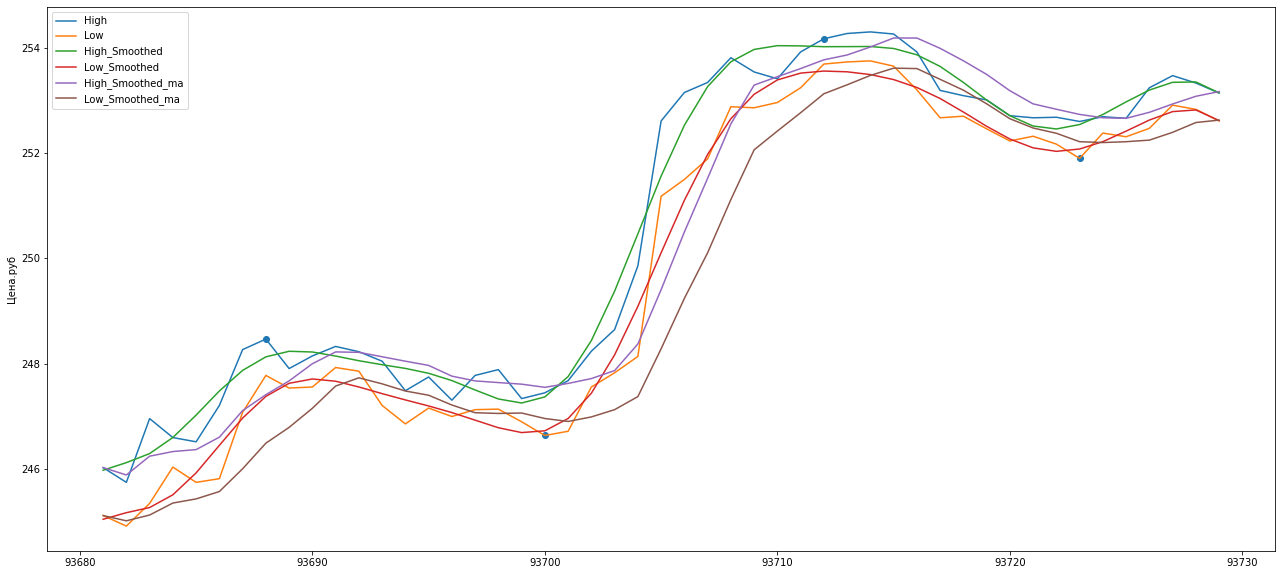

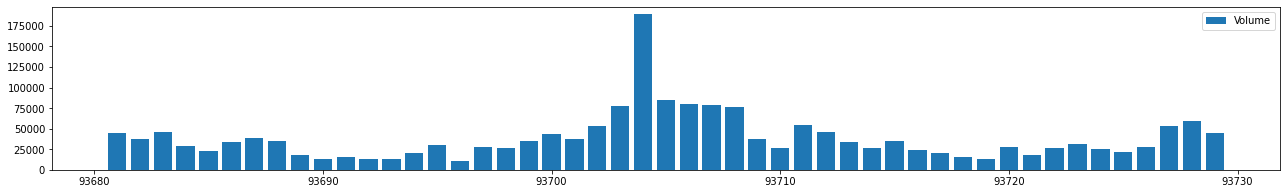

0
                       Open    High       Low   Close   Volume  Extr mirror
Date                                                                       
2007-01-03 17:30:00   29.91   30.01   29.8800   29.99  4931482   NaN    NaN
2007-01-03 17:45:00   29.95   29.98   29.8499   29.85  2478193   NaN    NaN
2007-01-03 18:00:00   29.85   29.92   29.8300   29.91  1454263   NaN    NaN
2007-01-03 18:15:00   29.90   29.97   29.8800   29.97  2963767   NaN    NaN
2007-01-03 18:30:00   29.97   30.00   29.9400   30.00  2840720   NaN    NaN
...                     ...     ...       ...     ...      ...   ...    ...
2021-05-07 21:45:00  252.48  253.24  252.4700  253.16    28202   NaN    NaN
2021-05-07 22:00:00  253.17  253.47  252.9100  253.20    53200   NaN    NaN
2021-05-07 22:15:00  253.20  253.33  252.8300  252.92    58910   NaN    NaN
2021-05-07 22:30:00  252.92  253.14  252.6100  252.73    45265   NaN    NaN
2021-05-07 22:45:00  252.68  253.22  252.3200  252.42   151258   NaN    NaN

[93731 ro

In [7]:
interval_start = -50 # Interval to look back
interval_end = -1
window_range = 3 # Window range fow smooth timeseries
window_for_extremums = 4 # Window of points to find extremums

data = data_initial.copy()  # Make copy of initial dataset
data['Date'] = data['<DATE>'].astype(str) + ' ' + data['<TIME>']  # Concatenate data columns as str
data.index = pd.to_datetime(data['Date'])  # Transform index to datetime format
del data['<DATE>'], data['<TIME>'], data['Date']  # Delete initial columns with date

# Rename columns
data = data.rename(columns={'<OPEN>': 'Open', '<HIGH>': 'High', '<LOW>': 'Low', '<CLOSE>': 'Close', '<VOL>': 'Volume' })

data_recover = data.copy()

#data = data_with_date.copy()  # Make copy of initial data with timestamp
time_st = data.index  # Store timestamps
data = data.reset_index(drop=True)  # Reset indexes to figures

def gauss_smooth(data):
  '''
  This function makes gaussian smooth of timeseries.
  arg: series
  The timeseries to smooth
  return: series
  Smoothed timeseries
  '''
  y_data = data.copy()
  y_data = y_data.reset_index(drop=True)
  x = y_data.index.values.reshape(-1,1)  # Take values of index as x
  y = y_data.values.reshape(-1,1).copy()  # Take values of series as y

  kernel = 0.2 * RBF(length_scale=0.8, length_scale_bounds=(1e-3, 8)) \
      + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-3, 1e+1))
  
  # Define Gaussian process
  gp = GaussianProcessRegressor(kernel=kernel,
                                alpha=0.0).fit(x, y)
  # Make smooth
  y_mean, y_cov = gp.predict(x, return_cov=True)
  return y_mean

def ma_smooth(data, period):
  data_smoothed = data.rolling(period, min_periods=1).mean()
  return np.array(data_smoothed)

high = data.iloc[interval_start:interval_end,1]
low = data.iloc[interval_start:interval_end,2]

high_smoothed = gauss_smooth(high)  # Smooth high timeseries
low_smoothed = gauss_smooth(low) # Smooth low timeseries

high_smoothed_ma = ma_smooth(high, 5)  # Smooth high timeseries
low_smoothed_ma = ma_smooth(low, 5) # Smooth low timeseries

def get_max_min(high, high_smoothed, low, low_smoothed, window_range):
  '''
  This function gets extremums of the timeseries using
  high: series
  The timeseries of High price values
  low: series
  The timeseries of Low price values
  range: int
  Size of the window to find real value near the smoothed extremum
  return: series of extremums, series of smoothed high, series of smoothed low
  '''
  local_max = argrelextrema(high_smoothed, np.greater, order=window_for_extremums)[0] # Find maximums
  local_min = argrelextrema(low_smoothed, np.less, order=window_for_extremums)[0] # Find minimums

  price_local_max = []
  for i in local_max:
    if (i>window_range) and (i < (len(high) - window_range)):
      price_local_max.append(high.iloc[i-window_range:i+window_range].idxmax())  # Find indexes of extremums

  price_local_min = []
  for i in local_min:
    if (i>window_range) and (i < (len(low) - window_range)):
      price_local_min.append(low.iloc[i-window_range:i+window_range].idxmin())  # Find indexes of extremums

  # Create dataframes for extremums
  maxima = pd.DataFrame(high.loc[price_local_max])
  minima = pd.DataFrame(low.loc[price_local_min])
  maxmin = pd.concat([maxima, minima]).sort_index()
  # Remove duplicates
  maxmin = maxmin[~maxmin.index.duplicated()]
  maxmin['Extr'] = maxmin.fillna(0).sum(axis=1)
  del maxmin['High'], maxmin['Low']

  return maxmin

# Get extremums and smoothed High, Low
maxmin = get_max_min(high, high_smoothed, low, low_smoothed, window_range )

col = data.columns.tolist()
# Draw the data in channels
plt.figure(figsize=(22,10))
for i in range(1,3):
  plt.plot(data.iloc[interval_start:interval_end,i], 
          label=col[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.plot(data.iloc[interval_start:interval_end].index, high_smoothed, label = 'High_Smoothed')
plt.plot(data.iloc[interval_start:interval_end].index, low_smoothed, label = 'Low_Smoothed')
plt.plot(data.iloc[interval_start:interval_end].index, high_smoothed_ma, label = 'High_Smoothed_ma')
plt.plot(data.iloc[interval_start:interval_end].index, low_smoothed_ma, label = 'Low_Smoothed_ma')
plt.scatter(maxmin.index, maxmin)
plt.legend()
plt.show()

# Draw channel volume
plt.figure(figsize=(22,3))
plt.bar(x=data.index[interval_start:interval_end], height=data.iloc[interval_start:interval_end,4], label="Volume")
plt.legend()
plt.show()

patterns_last_index = {'mirror':0}
print(patterns_last_index['mirror'])

def find_patterns(maxmin, df):
  '''
  This function finds patterns in series of extremums
  arg: series
  The series of extremums

  return: dictionary
  The dictionary with patterns
  '''
  points_in_patterns = 8
  mirror_extr_median_gap = 0.005
  mirror_median_gap = 0.002
  mirror_index_gap = 6

  for i in range(points_in_patterns, len(maxmin)+1):
    #window = maxmin.iloc[i-points_in_patterns:i].values
    window = maxmin.iloc[i-points_in_patterns:i]
    # for i in window.itertuples():
    #   print(i[0],i[1])
    #a,b,c,d,e, f,g,h = window[0:points_in_patterns]
    a,b,c,d,e, f,g,h = window.itertuples()

    # Find mirror level
    if (h[1] < g[1] and h[1] > f[1] and h[1] <= e[1]*(1+mirror_median_gap) and 
        h[1] >= e[1]*(1-mirror_median_gap) and g[1] > f[1] and g[1] > e[1] and
        f[1] < e[1] and (g[1]-h[1])/h[1] > mirror_extr_median_gap and 
        (h[1]-f[1])/h[1] > mirror_extr_median_gap and
        (f[0]-e[0]) >= mirror_index_gap and (h[0]-g[0]) >= mirror_index_gap) :
      mirror_levels_temp = []
      mirror_levels_temp.append([maxmin.index[i-points_in_patterns+4:i].values.reshape(-1,1),maxmin.iloc[i-points_in_patterns+4:i].values])
      mirror_levels_temp = np.squeeze(mirror_levels_temp)
      mirror_levels_df = pd.DataFrame(data=mirror_levels_temp[1], index=mirror_levels_temp[0].astype(int), columns=['mirror'])

      if df.empty:
        df = mirror_levels_df
        patterns_last_index.update([('mirror', mirror_levels_df.index[-1])])
      elif mirror_levels_df.index[-1] != patterns_last_index['mirror']:
        df = df.append(mirror_levels_df)   
        patterns_last_index.update([('mirror', mirror_levels_df.index[-1])])

  return df

patterns = pd.DataFrame(columns=['mirror'])
patterns_last_index = {}
patterns = find_patterns(maxmin, patterns)

if patterns.empty:
  pass
else:
  patterns.index = time_st[patterns.index]

# Return timestamps as indexes
maxmin.index = time_st[maxmin.index]
data.index = time_st[data.index]

# Join extremums to the dataset
data = data.join(maxmin, how='left')
data = data.join(patterns, how='left')
print(data)

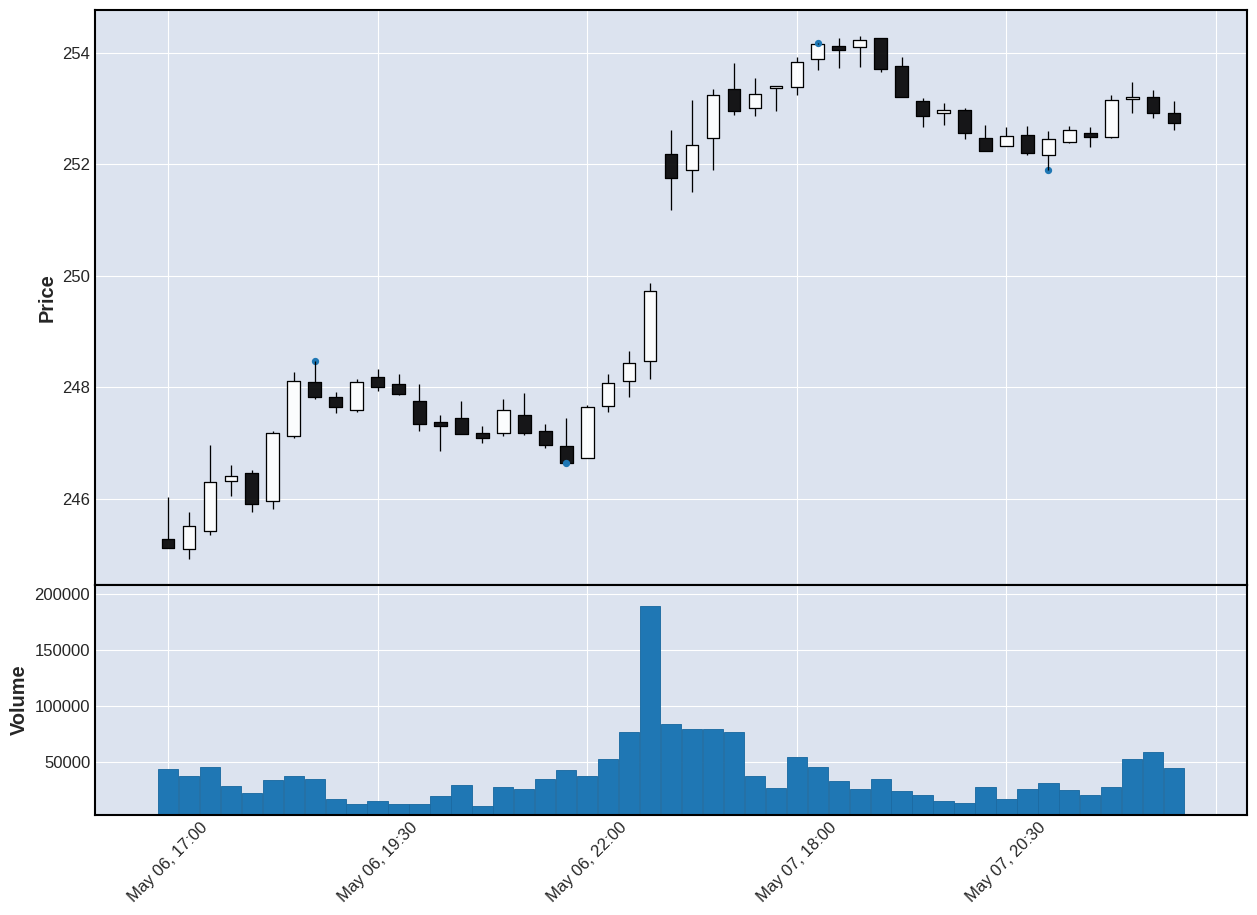

In [8]:
# Plot candels with extremums
if data.iloc[interval_start:interval_end,6].notna().sum() == 0:
  add_maxmin = [mpf.make_addplot(data.iloc[interval_start:interval_end,5], type='scatter', secondary_y=False)]
else:
  add_maxmin = [mpf.make_addplot(data.iloc[interval_start:interval_end,5], type='scatter', secondary_y=False),
              mpf.make_addplot(data.iloc[interval_start:interval_end,6], type='scatter', secondary_y=False, color='g')]
  
mpf.plot(data.iloc[interval_start:interval_end,:5], type='candle', volume=True, addplot=add_maxmin, figscale=2)
plt.show() 

In [9]:
def draw_pattern(df_input, maxmin, pattern):
  df = df_input.copy()
  # Return timestamps as indexes
  maxmin.index = time_st[maxmin.index]
  df.index = time_st[df.index]
  pattern.index = time_st[pattern.index]
  # Join extremums to the dataset
  df = df.join(maxmin, how='left')
  df = df.join(pattern, how='left')

  # Plot candels with extremums
  add_maxmin = [mpf.make_addplot(df.iloc[:,5], type='scatter', secondary_y=False),
                mpf.make_addplot(df.iloc[:,6], type='scatter', secondary_y=False, color='g')]
  mpf.plot(df.iloc[:,:5], type='candle', volume=True, addplot=add_maxmin, figscale=1)
  plt.show() 


  0%|          | 75/93631 [00:15<5:36:58,  4.63it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
  0%|          | 88/93631 [00:18<5:30:02,  4.72it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
  0%|          | 91/93631 [00:18<6:05:20,  4.27it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TER

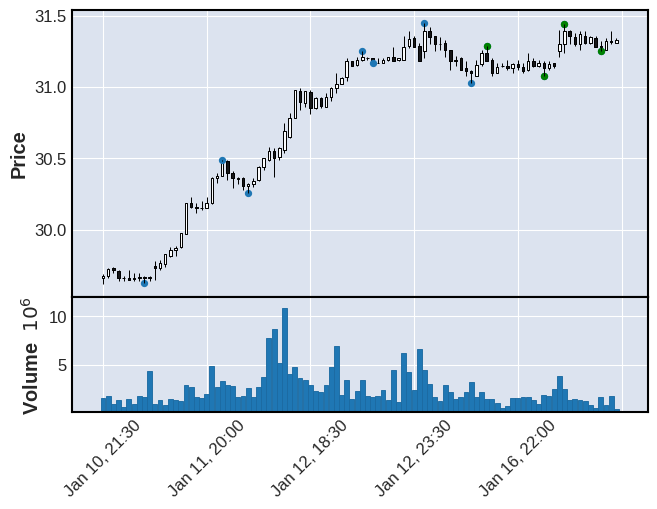

  0%|          | 246/93631 [00:54<4:02:12,  6.43it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
  0%|          | 253/93631 [00:55<4:19:02,  6.01it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
  0%|          | 267/93631 [00:58<4:23:36,  5.90it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_

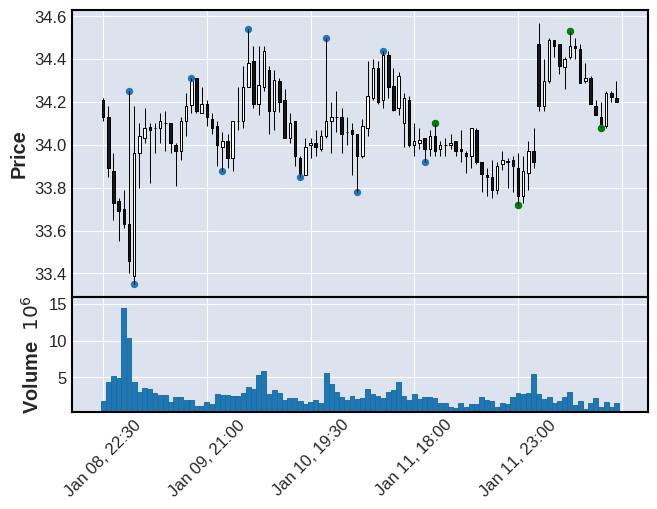

  7%|▋         | 6652/93631 [26:07<6:11:24,  3.90it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
  7%|▋         | 6695/93631 [26:17<4:14:14,  5.70it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
  7%|▋         | 6696/93631 [26:17<5:23:02,  4.49it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORM

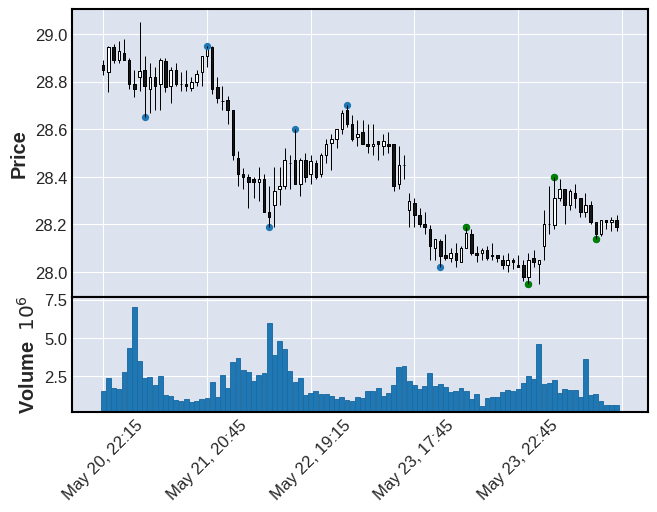

 10%|▉         | 9041/93631 [35:44<5:31:11,  4.26it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 10%|▉         | 9111/93631 [35:58<5:19:19,  4.41it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 10%|▉         | 9118/93631 [36:00<5:02:17,  4.66it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORM

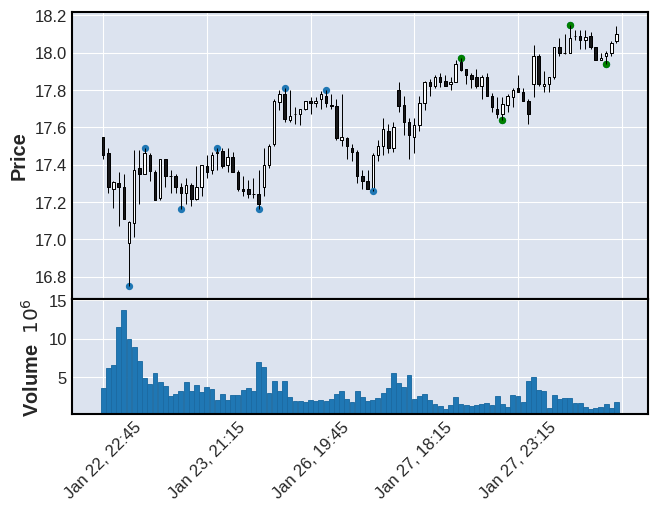

 14%|█▍        | 13475/93631 [53:52<6:19:02,  3.52it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 14%|█▍        | 13480/93631 [53:54<6:50:51,  3.25it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 14%|█▍        | 13487/93631 [53:56<6:35:16,  3.38it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABN

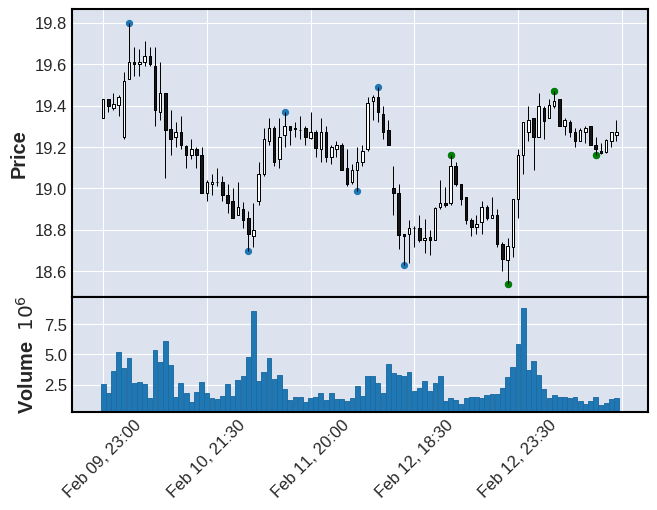

 15%|█▍        | 13796/93631 [55:15<5:27:38,  4.06it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 15%|█▍        | 13800/93631 [55:16<5:31:38,  4.01it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 15%|█▍        | 13820/93631 [55:21<4:38:51,  4.77it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABN

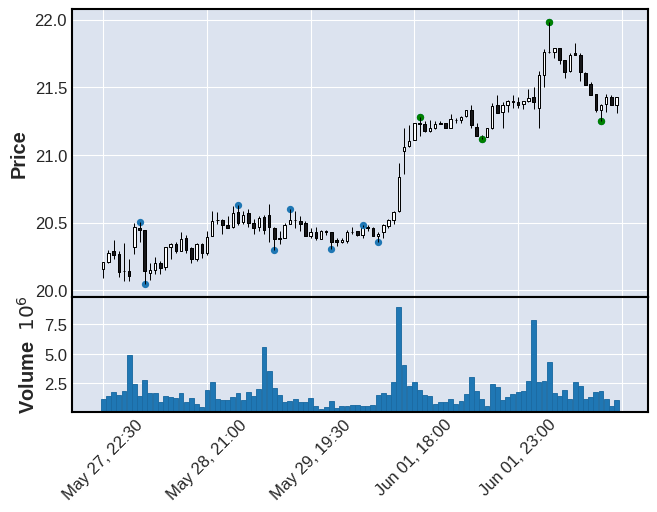

 17%|█▋        | 15678/93631 [1:02:52<8:16:07,  2.62it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 17%|█▋        | 15701/93631 [1:02:58<4:30:55,  4.79it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 17%|█▋        | 15721/93631 [1:03:02<4:27:05,  4.86it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

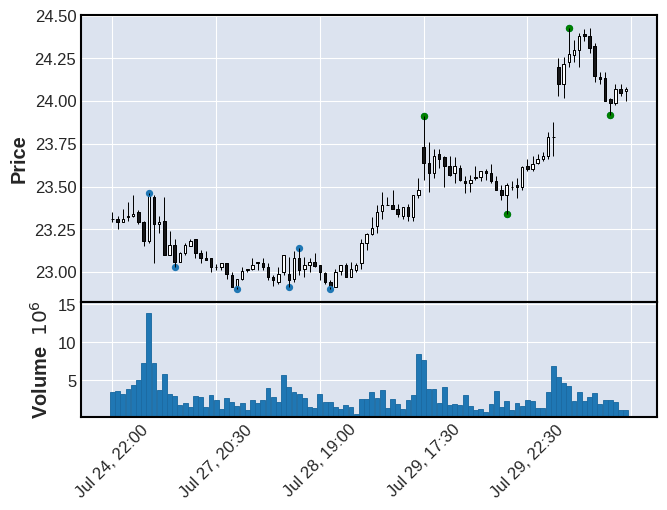

 18%|█▊        | 16758/93631 [1:07:11<3:50:03,  5.57it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 18%|█▊        | 16780/93631 [1:07:17<5:38:30,  3.78it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 18%|█▊        | 16788/93631 [1:07:19<4:54:24,  4.35it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

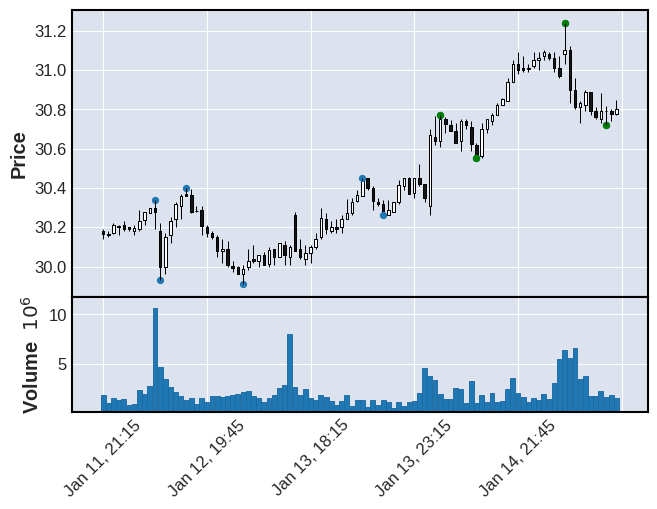

 21%|██        | 19806/93631 [1:19:19<5:27:37,  3.76it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 21%|██        | 19822/93631 [1:19:21<2:53:22,  7.10it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 21%|██        | 19877/93631 [1:19:33<3:46:41,  5.42it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

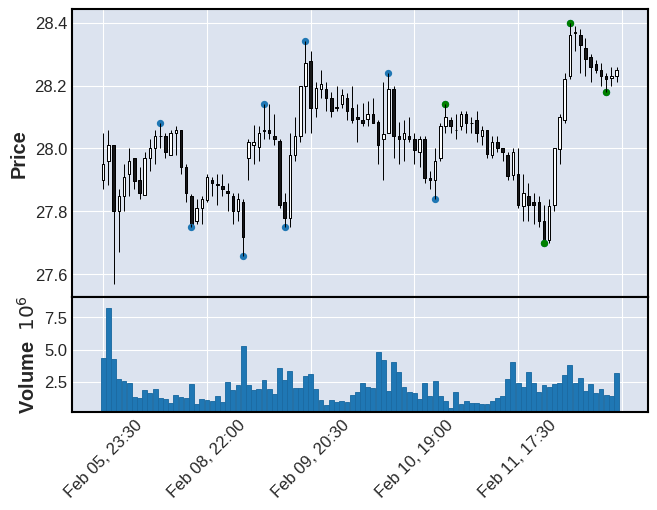

 22%|██▏       | 20258/93631 [1:21:09<6:08:34,  3.32it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 22%|██▏       | 20329/93631 [1:21:25<4:48:43,  4.23it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 22%|██▏       | 20374/93631 [1:21:36<5:14:10,  3.89it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

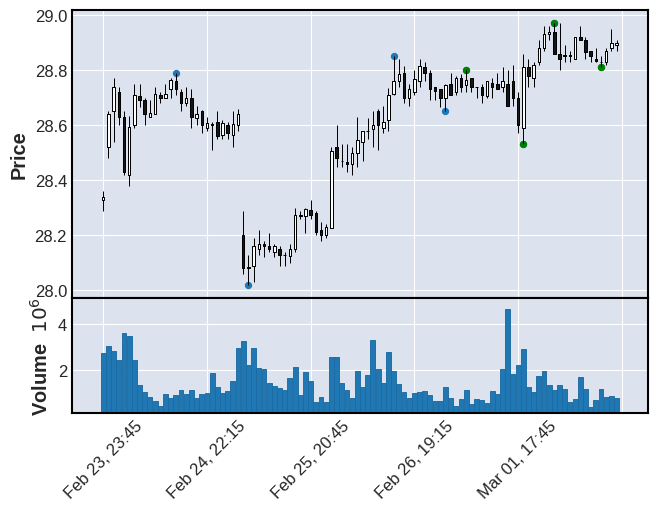

 22%|██▏       | 20579/93631 [1:22:25<4:39:58,  4.35it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 22%|██▏       | 20604/93631 [1:22:30<4:20:38,  4.67it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 22%|██▏       | 20607/93631 [1:22:31<4:32:38,  4.46it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

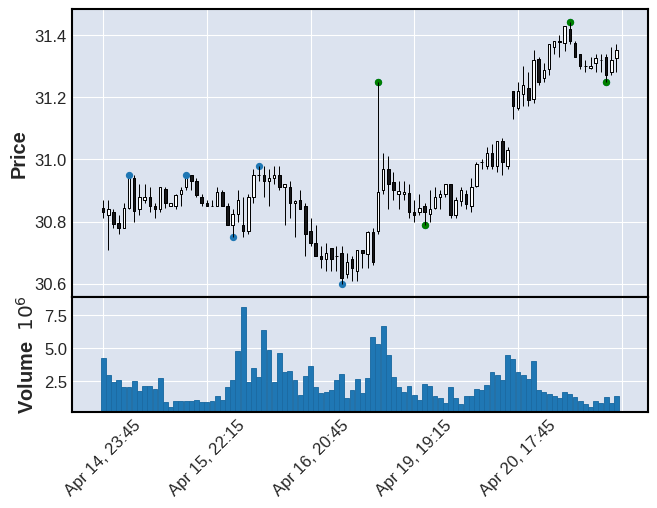

 23%|██▎       | 21481/93631 [1:25:58<5:42:21,  3.51it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 23%|██▎       | 21497/93631 [1:26:02<4:38:18,  4.32it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 23%|██▎       | 21514/93631 [1:26:06<5:12:20,  3.85it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

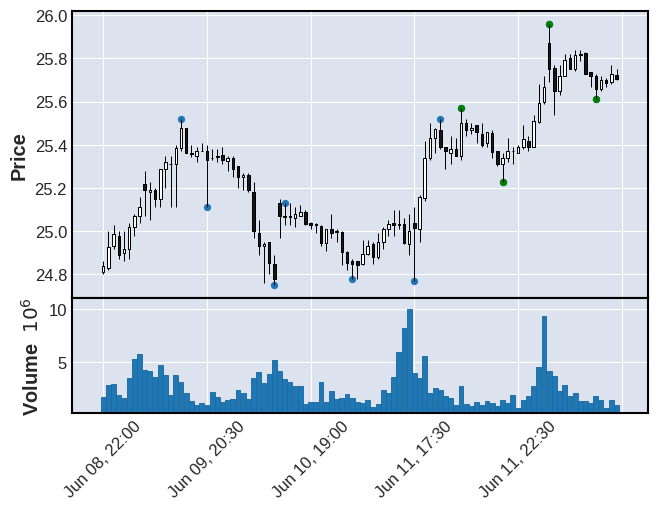

 24%|██▍       | 22456/93631 [1:30:00<4:44:08,  4.17it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 24%|██▍       | 22490/93631 [1:30:08<4:45:28,  4.15it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 24%|██▍       | 22500/93631 [1:30:11<4:36:57,  4.28it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

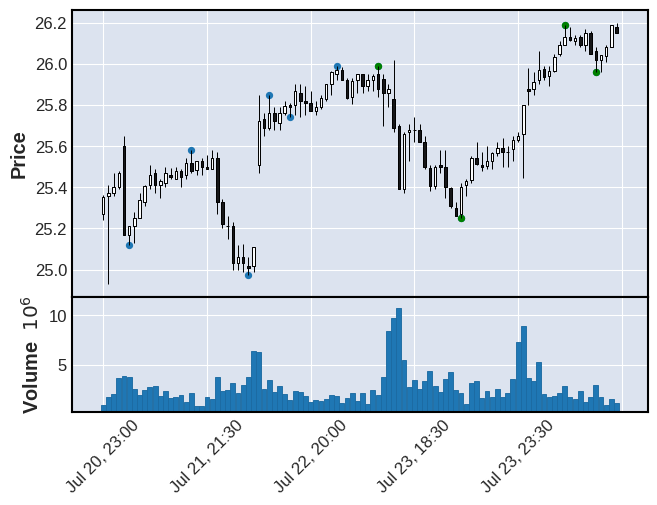

 25%|██▍       | 23187/93631 [1:33:07<10:15:27,  1.91it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 25%|██▍       | 23188/93631 [1:33:08<10:14:26,  1.91it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 25%|██▍       | 23200/93631 [1:33:11<4:29:26,  4.36it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status

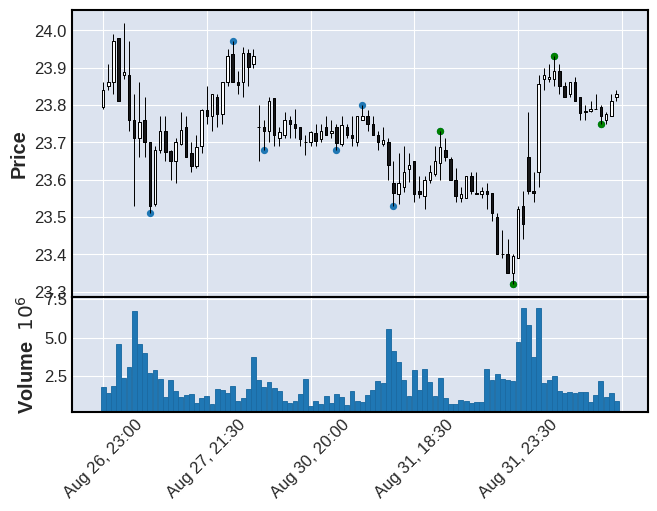

 26%|██▌       | 23917/93631 [1:36:05<4:01:17,  4.82it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 26%|██▌       | 23952/93631 [1:36:14<3:58:22,  4.87it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 26%|██▌       | 23958/93631 [1:36:15<4:22:01,  4.43it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (stat

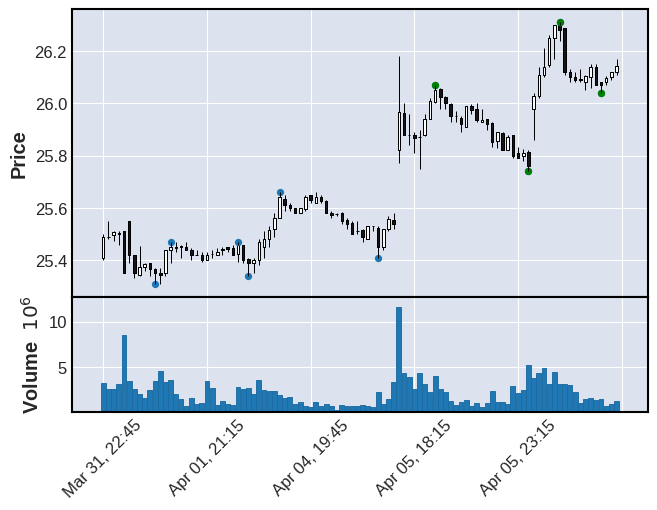

 30%|██▉       | 27869/93631 [1:52:07<3:35:26,  5.09it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 30%|██▉       | 27962/93631 [1:52:30<4:47:45,  3.80it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 30%|██▉       | 27983/93631 [1:52:35<4:31:58,  4.02it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

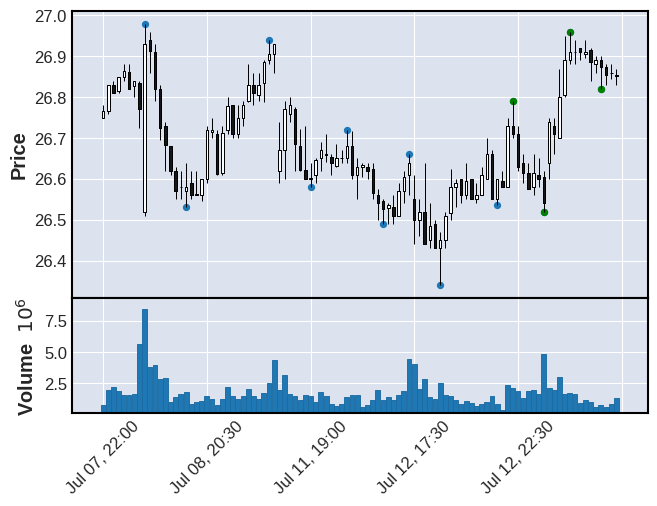

 32%|███▏      | 29525/93631 [1:58:46<6:11:03,  2.88it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 32%|███▏      | 29560/93631 [1:58:55<4:13:01,  4.22it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 32%|███▏      | 29581/93631 [1:59:00<5:21:10,  3.32it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

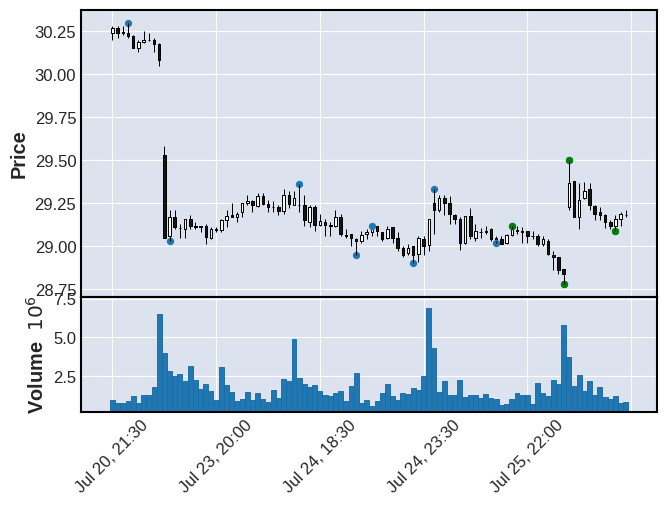

 39%|███▉      | 36345/93631 [2:27:37<4:20:11,  3.67it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 39%|███▉      | 36347/93631 [2:27:37<4:11:07,  3.80it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 39%|███▉      | 36384/93631 [2:27:46<3:31:50,  4.50it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

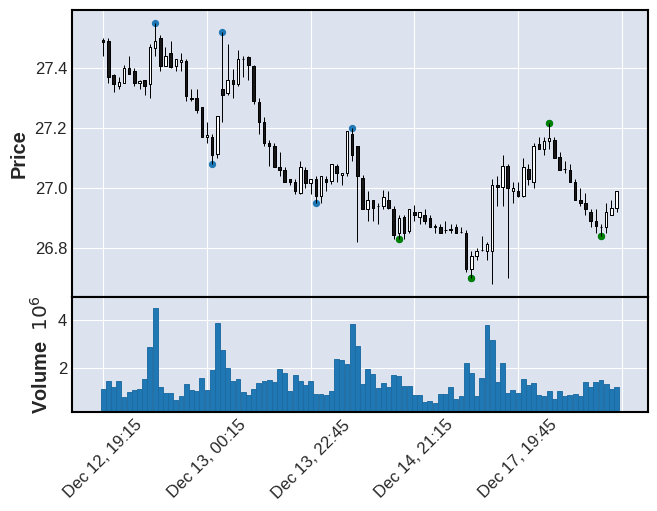

 42%|████▏     | 38903/93631 [2:38:05<3:37:44,  4.19it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 42%|████▏     | 38912/93631 [2:38:07<3:30:23,  4.33it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 42%|████▏     | 38922/93631 [2:38:10<4:19:15,  3.52it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

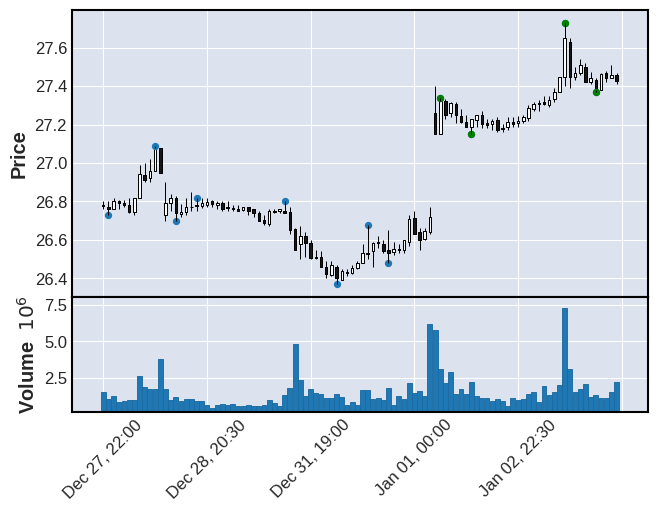

 42%|████▏     | 39157/93631 [2:39:12<5:49:39,  2.60it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 42%|████▏     | 39167/93631 [2:39:15<4:48:13,  3.15it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 42%|████▏     | 39170/93631 [2:39:16<5:03:33,  2.99it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

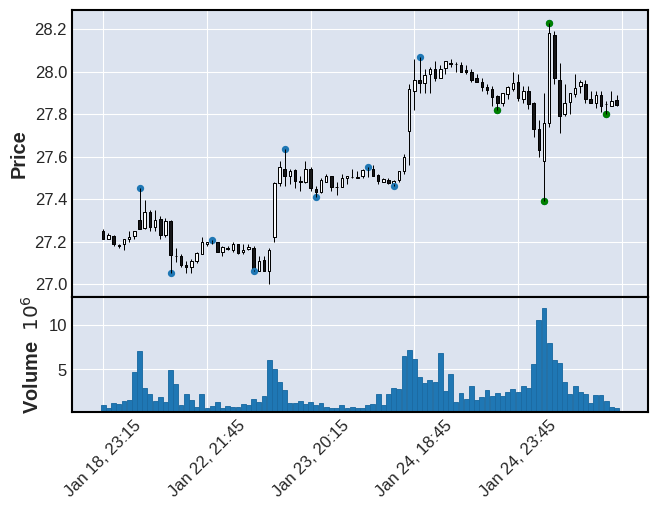

 42%|████▏     | 39552/93631 [2:40:48<6:16:30,  2.39it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 42%|████▏     | 39566/93631 [2:40:51<3:24:25,  4.41it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 42%|████▏     | 39569/93631 [2:40:52<3:53:21,  3.86it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

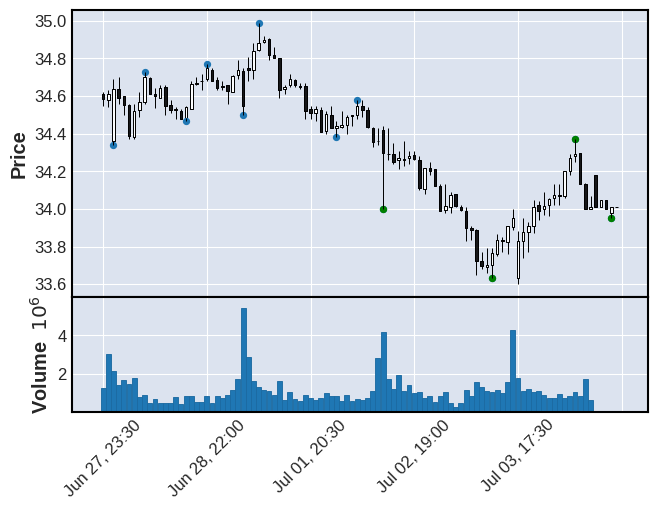

 45%|████▌     | 42503/93631 [2:53:08<3:14:17,  4.39it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 45%|████▌     | 42510/93631 [2:53:10<4:03:40,  3.50it/s]

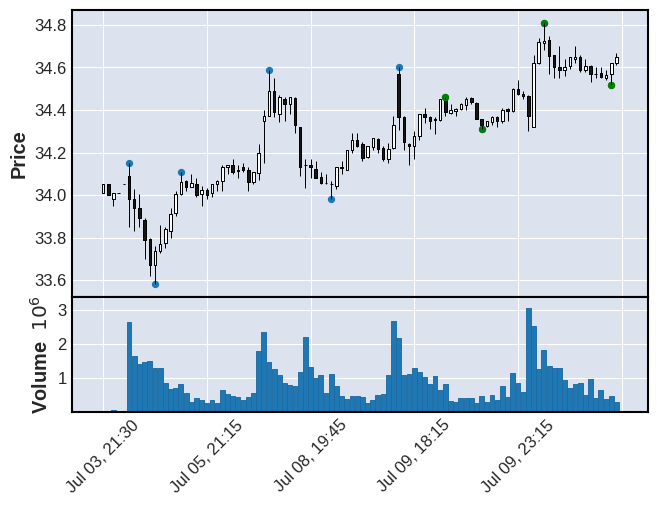

 45%|████▌     | 42560/93631 [2:53:24<3:44:42,  3.79it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 45%|████▌     | 42572/93631 [2:53:27<3:56:54,  3.59it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 45%|████▌     | 42574/93631 [2:53:28<4:12:22,  3.37it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

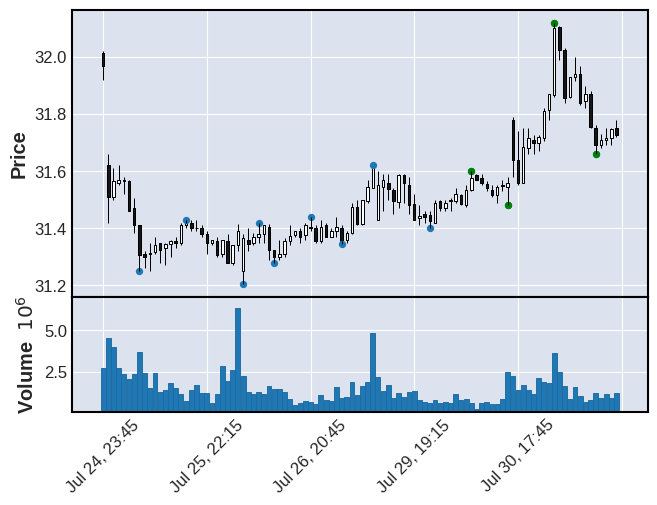

 46%|████▌     | 42895/93631 [2:54:48<4:18:28,  3.27it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 46%|████▌     | 43015/93631 [2:55:19<3:25:36,  4.10it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 46%|████▌     | 43017/93631 [2:55:19<3:36:06,  3.90it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

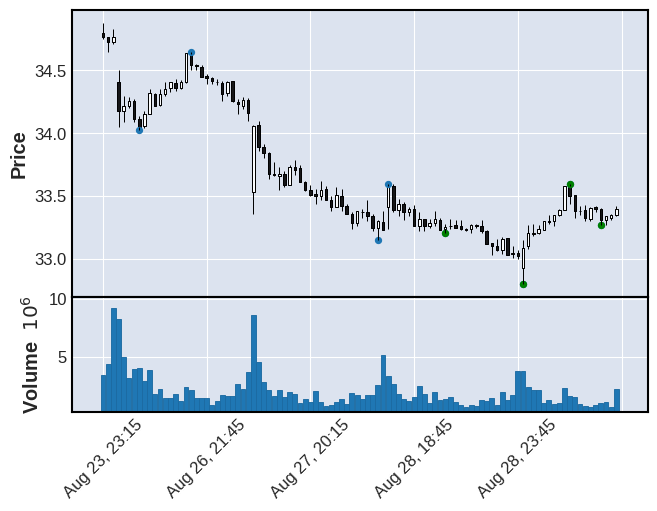

 46%|████▋     | 43454/93631 [2:57:10<3:41:31,  3.78it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 46%|████▋     | 43475/93631 [2:57:15<3:47:09,  3.68it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 46%|████▋     | 43498/93631 [2:57:21<3:05:19,  4.51it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

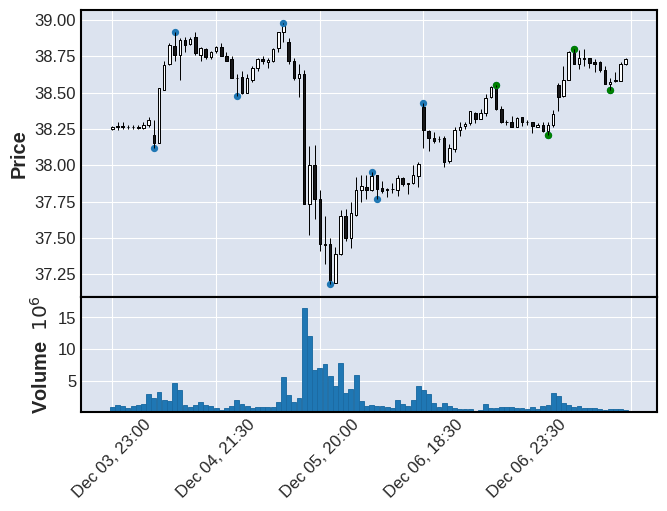

 48%|████▊     | 45257/93631 [3:04:54<3:55:04,  3.43it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 48%|████▊     | 45260/93631 [3:04:55<4:19:50,  3.10it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 48%|████▊     | 45263/93631 [3:04:56<4:36:32,  2.92it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

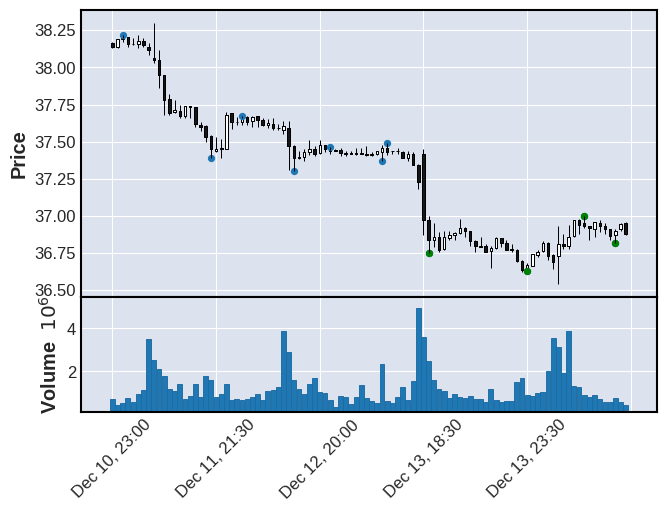

 49%|████▊     | 45423/93631 [3:05:41<3:36:12,  3.72it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 49%|████▊     | 45431/93631 [3:05:43<4:00:19,  3.34it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 49%|████▊     | 45435/93631 [3:05:45<3:29:00,  3.84it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

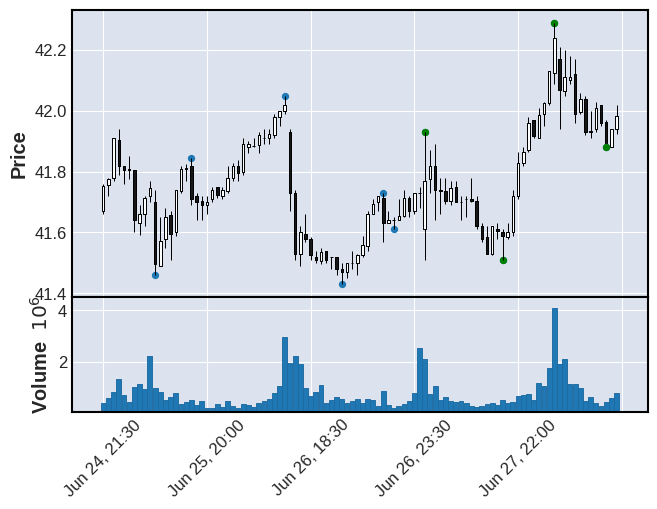

 52%|█████▏    | 48860/93631 [3:21:40<3:39:54,  3.39it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 52%|█████▏    | 48885/93631 [3:21:48<3:43:35,  3.34it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 52%|█████▏    | 48886/93631 [3:21:48<4:09:46,  2.99it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

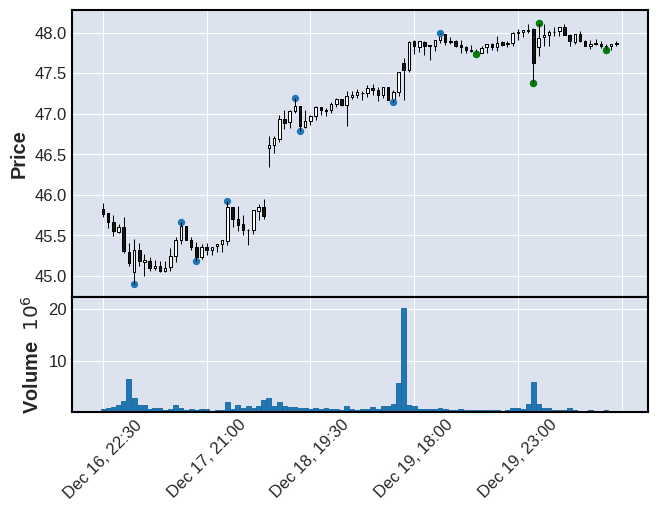

 56%|█████▌    | 52030/93631 [3:36:09<3:13:11,  3.59it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 56%|█████▌    | 52043/93631 [3:36:12<3:16:04,  3.54it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 56%|█████▌    | 52052/93631 [3:36:14<2:41:55,  4.28it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

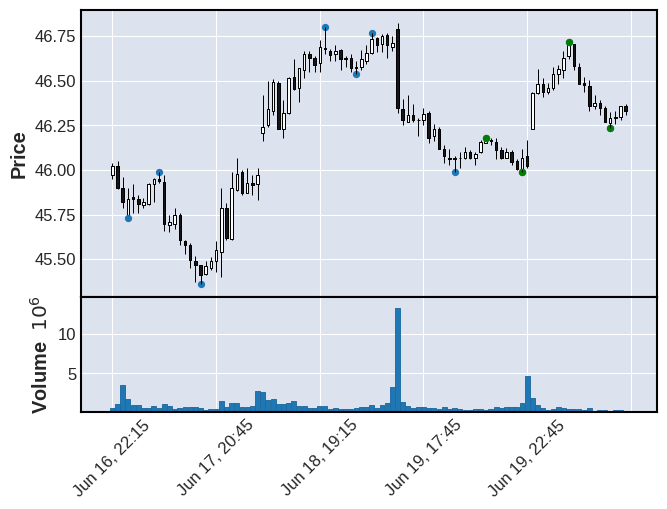

 59%|█████▉    | 55244/93631 [3:50:39<4:00:43,  2.66it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 59%|█████▉    | 55245/93631 [3:50:40<3:55:28,  2.72it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 59%|█████▉    | 55298/93631 [3:50:54<3:09:16,  3.38it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

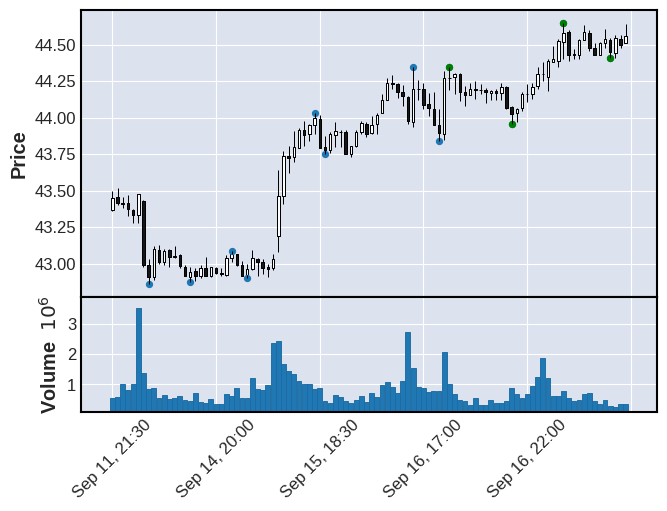

 61%|██████    | 56827/93631 [3:57:48<4:05:37,  2.50it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 61%|██████    | 56829/93631 [3:57:49<3:51:59,  2.64it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 61%|██████    | 56831/93631 [3:57:50<3:59:00,  2.57it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

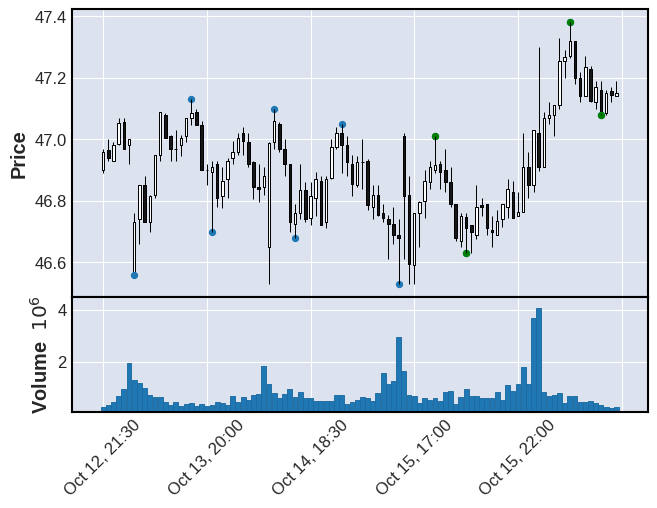

 61%|██████▏   | 57370/93631 [4:00:21<4:59:25,  2.02it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 61%|██████▏   | 57372/93631 [4:00:22<4:16:34,  2.36it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 61%|██████▏   | 57391/93631 [4:00:27<2:25:08,  4.16it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

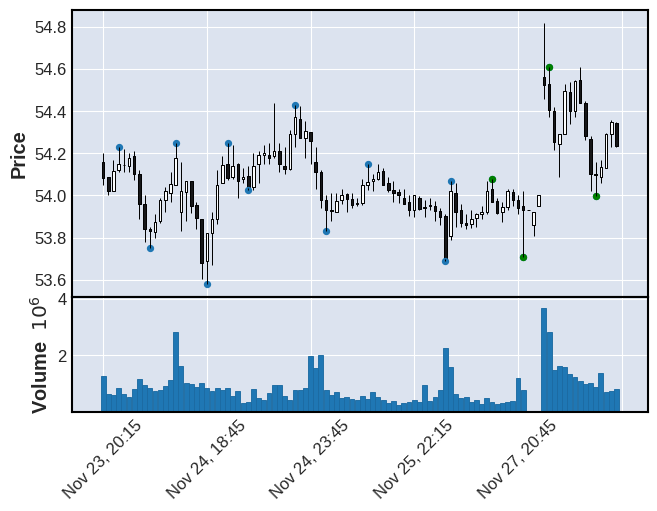

 62%|██████▏   | 58143/93631 [4:03:55<3:30:51,  2.81it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 62%|██████▏   | 58183/93631 [4:04:06<2:35:26,  3.80it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 62%|██████▏   | 58195/93631 [4:04:10<3:00:30,  3.27it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

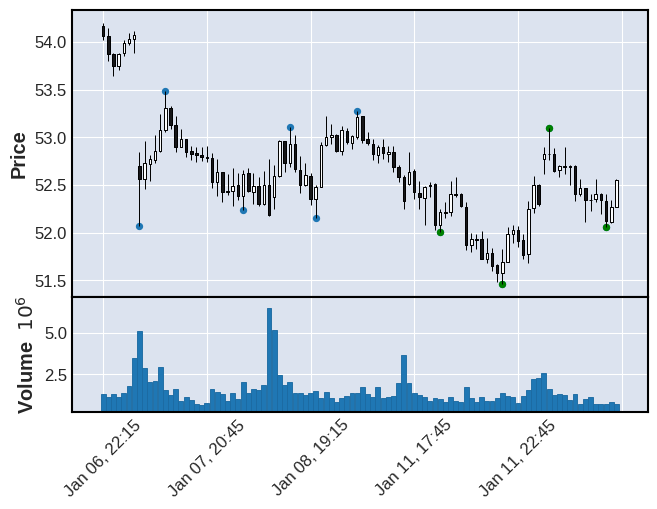

 63%|██████▎   | 58910/93631 [4:07:19<2:06:27,  4.58it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 63%|██████▎   | 58939/93631 [4:07:26<2:25:40,  3.97it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 63%|██████▎   | 58985/93631 [4:07:37<2:50:30,  3.39it/s]/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2

In [ ]:
def find_patterns_train(maxmin):
  '''
  This function finds patterns in series of extremums
  arg: series
  The series of extremums

  return: dictionary
  The dictionary with patterns
  '''
  points_in_patterns = 8
  mirror_extr_median_gap = 0.005
  mirror_median_gap = 0.002
  mirror_index_gap = 6
  pattern_df = pd.DataFrame()
  if len(maxmin) >= points_in_patterns:  # If enough extremums for patterns
    window = maxmin.iloc[-points_in_patterns:]
    a,b,c,d,e, f,g,h = window.itertuples()

    # Find mirror level
    if (h[1] < g[1] and h[1] > f[1] and h[1] <= e[1]*(1+mirror_median_gap) and 
        h[1] >= e[1]*(1-mirror_median_gap) and g[1] > f[1] and g[1] > e[1] and
        f[1] < e[1] and (g[1]-h[1])/h[1] > mirror_extr_median_gap and 
        (h[1]-f[1])/h[1] > mirror_extr_median_gap and
        (f[0]-e[0]) >= mirror_index_gap and (h[0]-g[0]) >= mirror_index_gap) :
      pattern_temp = []  # Temporary array
      # Put indexes and values of points in temporary array
      pattern_temp.append([maxmin.index[-points_in_patterns+4:].values.reshape(-1,1),maxmin.iloc[-points_in_patterns+4:].values])
      pattern_temp = np.squeeze(pattern_temp)  # Squeeze temporary array to reduce axis with shape 1
      # Create dataframe and put there the points of pattern with original indexes
      pattern_df = pd.DataFrame(data=pattern_temp[1], index=pattern_temp[0].astype(int), columns=['mirror'])
       
  return pattern_df

from IPython.display import clear_output
from tqdm import tqdm

data = data_recover.copy()
rolling_window = 100  # Range where to find patterns
window_step = 1  # Step to move window through dataset
gap_from_current = 5
max_data_size = len(data)

#data = data_with_date.copy()  # Make copy of initial data with timestamp
time_st = data.index  # Store timestamps
data = data.reset_index(drop=True)  # Reset indexes to figures
patterns_main = pd.DataFrame(columns=['mirror'])
patterns_last_index = {}
patterns_max_price = {}
last_pattern_point = {}
x_train = []
y_train = []

current_position = rolling_window # Current position of the window
for i in tqdm(range(current_position, max_data_size, window_step), position=0): #
  current_position = i
  current_price = data.iloc[current_position, 3]
  x_train.append(data.iloc[current_position - rolling_window : current_position, :4].values)
  #clear_output(wait=True)

  high = data.iloc[current_position - rolling_window : current_position, 1]
  low = data.iloc[current_position - rolling_window : current_position, 2]
  high_smoothed = gauss_smooth(high)  # Smooth high timeseries
  low_smoothed = gauss_smooth(low) # Smooth low timeseries
  # Get extremums and smoothed High, Low
  maxmin = get_max_min(high, high_smoothed, low, low_smoothed, window_range )

  # Get patterns
  pattern_df = find_patterns_train(maxmin)
  
  if pattern_df.empty:  # If no patterns
    y_train = np.append(y_train,[0])
  else:
    patterns_max_price.update([('mirror', pattern_df['mirror'].max())])
    last_pattern_point.update([('mirror', pattern_df.iloc[-1,0])])

    # Add dataframe with current pattern into common patterns dataframe
    if patterns_main.empty: 
      patterns_last_index.update([('mirror', pattern_df.index[-1])])  # Update last pattern index
      if (current_price < patterns_max_price['mirror'] and 
          current_price >= last_pattern_point['mirror'] and
          (data.index[current_position]-patterns_last_index['mirror']) <= gap_from_current ): # If pattern just has arrived ()
        patterns_main = pattern_df
        y_train = np.append(y_train, [1])
        draw_pattern(data.iloc[current_position - rolling_window:current_position,:], maxmin, pattern_df)
      else:
        y_train = np.append(y_train, [0])

    elif pattern_df.index[-1] != patterns_last_index['mirror']:  # If it is a new pattern
      patterns_last_index.update([('mirror', pattern_df.index[-1])])  # And update last pattern index
      if (current_price < patterns_max_price['mirror'] and 
          current_price >= last_pattern_point['mirror'] and
          (data.index[current_position]-patterns_last_index['mirror']) <= gap_from_current): # If pattern just has arrived ( )
        patterns_main = patterns_main.append(pattern_df)  # Add to common dataframe
        y_train = np.append(y_train, [1])
        draw_pattern(data.iloc[current_position - rolling_window:current_position,:], maxmin, pattern_df)
      else:
        y_train = np.append(y_train, [0])
    else:
      y_train = np.append(y_train, [0])

x_train = np.array(x_train)
print(x_train.shape)
print(y_train.shape)
 

In [1]:
print(x_train[0])
print(y_train[y_train==1].count())

NameError: ignored

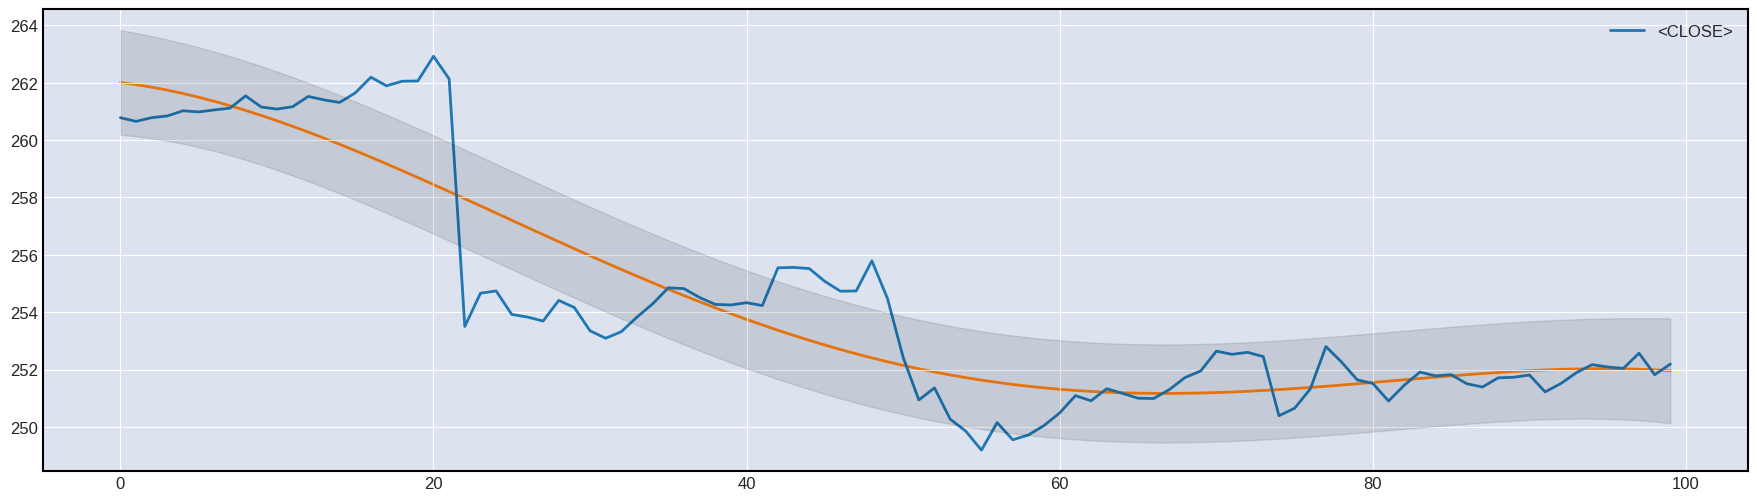

In [ ]:
# Test of gaussian process
interval = -100
y_data = data.iloc[interval:,3].copy()
y_data = y_data.reset_index(drop=True)
x = y_data.index.values.reshape(-1,1)
y = y_data.values.reshape(-1,1).copy()

kernel = 0.2 * RBF(length_scale=0.9, length_scale_bounds=(1e-5, 1e+2)) \
    + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-3, 1e+2))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(x, y)

y_mean, y_cov = gp.predict(x, return_cov=True)
plt.figure(figsize=(22,6))
plt.plot(y_data, zorder=7, label='<CLOSE>')
plt.plot(x, y_mean, zorder=0)
plt.fill_between(x.reshape(1,-1)[0], y_mean.reshape(1,-1)[0] - np.sqrt(np.diag(y_cov)),
                 y_mean.reshape(1,-1)[0] + np.sqrt(np.diag(y_cov)),
                 alpha=0.1, color='k', zorder=9)

plt.legend()
plt.show()